# Comparative Analysis of BT Segment and OD Data
***
<br>
We wish to conduct a comparative analysis of OD Data and Bluetooth Segment data. For each step in the analysis, key highlights are bolded and italicized.

<br>
## ***Objectives***:

<br>
* Discover which dataset is more comprehensive

<br>
* Investigate the discrepancies between the datasets

<br>
## ***High-Level Key Findings***

<br>
* **35%** of OD Data can be potentially represented via Bluetooth Segments: i.e. for a path total of x, there are x-1 segments. 

<br>
* With regards to the 65% that do not match, a majority of these are just missing 1-2 segments. However, there are paths that are missing 5 or more BT segments

<br>
* For a simple 'A to B' path, approximately **84%** of data are accurately represented. However, for path lengths of 3 (i.e. simply one interesection more than an A to B path), this number drops to around 40%. As paths become **more complicated**, the percentage of BT Segments representing OD Data **decreses**. 

<br>
* **8.64%** of paths that were seemingly being represented by BT Segments (i.e. 8.64% of 35%) had segments that did not correspond with the points in the path

<br>
* **7.12%** of paths with path total = 2 had segments that did not correspond with the points in the path

<br>
* **11.9%** of paths with path total > 2 had segments that did not correspond with the points in the path

<br>
* As path total **increases**, the percentage of paths that contain segments that did not correspond with the points in the path **increases** as well


<br>
Below is a summary of relevant percentages for different paths. The second column contains the percentage of OD Data can be potentially represented via Bluetooth Segments. The third contains the percentage of paths from the second column that contain segments that perfectly correspond with points in the path. The final column contains the grand percentage of paths that have perfectly corresponding segments, i.e. a multiplication of the second and third column.


In [53]:
arr = [[2, len(notmatching.loc[notmatching['path_total'] == 2])/len(df.loc[df['path_total'] ==2])], 
     [3, len(notmatching.loc[notmatching['path_total'] == 3].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==3].groupby(['datetime_bin', 'userid']))],
     [4, len(notmatching.loc[notmatching['path_total'] == 4].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==4].groupby(['datetime_bin', 'userid']))],
     [5, len(notmatching.loc[notmatching['path_total'] == 5].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==5].groupby(['datetime_bin', 'userid']))],
     [6, len(notmatching.loc[notmatching['path_total'] == 6].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==6].groupby(['datetime_bin', 'userid']))],
     [7, len(notmatching.loc[notmatching['path_total'] == 7].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==7].groupby(['datetime_bin', 'userid']))],
     [8, len(notmatching.loc[notmatching['path_total'] == 8].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==8].groupby(['datetime_bin', 'userid']))],
     [9, len(notmatching.loc[notmatching['path_total'] == 9].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==9].groupby(['datetime_bin', 'userid']))],
     [10, len(notmatching.loc[notmatching['path_total'] == 10].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==10].groupby(['datetime_bin', 'userid']))],
     [11, len(notmatching.loc[notmatching['path_total'] == 11].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==11].groupby(['datetime_bin', 'userid']))]]

y = [2475/2952, 927/2276,  371/1737, 179/1463,  98/1245, 64/781, 37/552, 29/313, 16/208, 16/186]
for i in arr:
    i[1] = 1-i[1]
    
import math
i = 0 
while i <= len(arr)-1:
    arr[i] = [(arr[i][0])] + [(y[i])] + [(arr[i][1])]
    arr[i].append(arr[i][1]*arr[i][2])
    arr[i][1] = str(round(arr[i][1] * 100, 2)) + '%'
    arr[i][2] = str(round(arr[i][2] * 100, 2)) + '%'
    arr[i][3] = str(round(arr[i][3] * 100, 2)) + '%'
    i += 1

columns = ['Path Total', 'Path Total Matches Seg Total', 'All Segs Match Path List', 'Overall']
pd.DataFrame(arr, columns = columns)

,Path Total,Path Total Matches Seg Total,All Segs Match Path List,Overall
0,2,83.84%,92.88%,77.87%
1,3,40.73%,95.98%,39.09%
2,4,21.36%,86.6%,18.5%
3,5,12.24%,80.22%,9.81%
4,6,7.87%,75.0%,5.9%
5,7,8.19%,63.64%,5.21%
6,8,6.7%,69.23%,4.64%
7,9,9.27%,82.76%,7.67%
8,10,7.69%,81.25%,6.25%
9,11,8.6%,68.75%,5.91%


# First Steps
***
We grab the necessary data. We will be working with Bluetooth Segment Data from January 1st. For now, we simply extract Origin Destination Data without a date filter. 

<br>
Firstly, two CSV's are grabbed from BlipTrack `BlipTrack Toronto_DT_OD_Start_End_Multiple_Outcomes_ut_20180101-20180102.csv` and `BlipTrack-Toronto_DT_OD_Others_Multiple_Outcomes_ut_20180101-20180102.csv`. The first is a binary containing data for the start of a route and the end of a route, with a 1 or 0 corresponding to whether or not that intersection was chosen as a start/end or not. The second is a table containing a particular route a vehicle has taken, with 1's and 0's corresponding to whether or not they passed a respective intersection on that route. 

<br>
With regards to Bluetooth Data, we simply pull our columns of interest and date range from a preexisting schema in the database. 

<br>
We import the two OD datasets into the alouis2 schema, under the names `startend_raw` and `others_raw`. We now have the OD Data we need, and we can begin filtering the datasets and creating necessary tables. 

## Creating our Primary Tables


<br>
We extract relevant data we will be working with by selecting only the columns we need. Below are the queries used to create `others_path` and `startend_path`, two tables containing relevant information from their raw counterparts. 

In [2]:
%load_ext sql
import matplotlib.pyplot as plt
import pandas as pd
import configparser
from psycopg2 import connect
import psycopg2.sql as pg
import pandas.io.sql as pandasql
from sqlalchemy import create_engine
import io


CONFIG = configparser.ConfigParser()
CONFIG.read(r'C:\Users\alouis2\Documents\Python Scripts\db.cfg')
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)
    

x = open('C:\\Users\\alouis2\\Documents\\Python Scripts\\andrew.txt', 'r')
x = x.readlines()[0]
%sql $x

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\sql\magic.py:4: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Bool, Int, Unicode


'Connected: alouis2@bigdata'

In [2]:
%%sql
CREATE TABLE others_path
(
  datetime_bin timestamp without time zone,
  userid bigint,  co_ba integer,  co_un integer,  co_pa integer,  du_ro integer,  du_df integer,
  du_ba integer,  du_sp integer,  du_un integer,  du_yo integer,  du_ja integer,  du_pa integer,
  qu_ro integer,  qu_df integer,  qu_st integer,  qu_ba integer,  qu_sp integer,  qu_un integer,
  qu_yo integer,  qu_ja integer,  qu_pa integer,  qu_bv integer,  rm_ba integer,  rm_sp integer,
  rm_un integer,  rm_yo integer,  rm_ja integer,  rm_pa integer,  ad_ba integer,  ad_sp integer,
  ad_un integer,  ad_yo integer,  ad_ja integer,  ad_pa integer,  kn_df integer,  kn_st integer,
  kn_ba integer,  kn_sp integer,  kn_un integer,  kn_yo integer,  kn_ja integer,  kn_pa integer,
  we_bj integer,  we_un integer,  we_yo integer,  fr_ba integer,  fr_sp integer,  fr_un integer,
  fr_yo integer,  fr_ja integer,  fr_pa integer,  fb_ba integer,  fb_sp integer,  fb_yk integer,
  ea_bv integer,  path_total integer
)
WITH (
  OIDS=FALSE
);
ALTER TABLE others_path
  OWNER TO alouis2;


(psycopg2.ProgrammingError) relation "others_path" already exists
 [SQL: 'CREATE TABLE others_path\n(\n  datetime_bin timestamp without time zone,\n  userid bigint,  co_ba integer,  co_un integer,  co_pa integer,  du_ro integer,  du_df integer,\n  du_ba integer,  du_sp integer,  du_un integer,  du_yo integer,  du_ja integer,  du_pa integer,\n  qu_ro integer,  qu_df integer,  qu_st integer,  qu_ba integer,  qu_sp integer,  qu_un integer,\n  qu_yo integer,  qu_ja integer,  qu_pa integer,  qu_bv integer,  rm_ba integer,  rm_sp integer,\n  rm_un integer,  rm_yo integer,  rm_ja integer,  rm_pa integer,  ad_ba integer,  ad_sp integer,\n  ad_un integer,  ad_yo integer,  ad_ja integer,  ad_pa integer,  kn_df integer,  kn_st integer,\n  kn_ba integer,  kn_sp integer,  kn_un integer,  kn_yo integer,  kn_ja integer,  kn_pa integer,\n  we_bj integer,  we_un integer,  we_yo integer,  fr_ba integer,  fr_sp integer,  fr_un integer,\n  fr_yo integer,  fr_ja integer,  fr_pa integer,  fb_ba integer,  fb

In [3]:
%%sql 
CREATE TABLE startend_path
(
  datetime_bin timestamp without time zone,
  userid bigint,
  s_co_ba integer,  s_co_un integer,  s_co_pa integer,  s_du_ro integer,  s_du_df integer,
  s_du_ba integer,  s_du_sp integer,  s_du_un integer,  s_du_yo integer,  s_du_ja integer,
  s_du_pa integer,  s_qu_ro integer,  s_qu_df integer,  s_qu_st integer,  s_qu_ba integer,
  s_qu_sp integer,  s_qu_un integer,  s_qu_yo integer,  s_qu_ja integer,  s_qu_pa integer,
  s_qu_bv integer,  s_rm_ba integer,  s_rm_sp integer,  s_rm_un integer,  s_rm_yo integer,
  s_rm_ja integer,  s_rm_pa integer,  s_ad_ba integer,  s_ad_sp integer,  s_ad_un integer,
  s_ad_yo integer,  s_ad_ja integer,  s_ad_pa integer,  s_kn_df integer,  s_kn_st integer,
  s_kn_ba integer,  s_kn_sp integer,  s_kn_un integer,  s_kn_yo integer,  s_kn_ja integer,
  s_kn_pa integer,  s_we_bj integer,  s_we_un integer,  s_we_yo integer,  s_fr_ba integer,
  s_fr_sp integer,  s_fr_un integer,  s_fr_yo integer,  s_fr_ja integer,  s_fr_pa integer,
  s_fb_ba integer,  s_fb_sp integer,  s_fb_yk integer,  s_ea_bv integer,  e_co_ba integer,
  e_co_un integer,  e_co_pa integer,  e_du_ro integer,  e_du_df integer,  e_du_ba integer,
  e_du_sp integer,  e_du_un integer,  e_du_yo integer,  e_du_ja integer,  e_du_pa integer,
  e_qu_ro integer,  e_qu_df integer,  e_qu_st integer,  e_qu_ba integer,  e_qu_sp integer,
  e_qu_un integer,  e_qu_yo integer,  e_qu_ja integer,  e_qu_pa integer,  e_qu_bv integer,
  e_rm_ba integer,  e_rm_sp integer,  e_rm_un integer,  e_rm_yo integer,  e_rm_ja integer,
  e_rm_pa integer,  e_ad_ba integer,  e_ad_sp integer,  e_ad_un integer,  e_ad_yo integer,
  e_ad_ja integer,  e_ad_pa integer,  e_kn_df integer,  e_kn_st integer,  e_kn_ba integer,
  e_kn_sp integer,  e_kn_un integer,  e_kn_yo integer,  e_kn_ja integer,  e_kn_pa integer,
  e_we_bj integer,  e_we_un integer,  e_we_yo integer,  e_fr_ba integer,  e_fr_sp integer,
  e_fr_un integer,  e_fr_yo integer,  e_fr_ja integer,  e_fr_pa integer,  e_fb_ba integer,
  e_fb_sp integer,  e_fb_yk integer,  e_ea_bv integer
)
WITH (
  OIDS=FALSE
);
ALTER TABLE startend_path
  OWNER TO alouis2;


(psycopg2.ProgrammingError) relation "startend_path" already exists
 [SQL: 'CREATE TABLE startend_path\n(\n  datetime_bin timestamp without time zone,\n  userid bigint,\n  s_co_ba integer,  s_co_un integer,  s_co_pa integer,  s_du_ro integer,  s_du_df integer,\n  s_du_ba integer,  s_du_sp integer,  s_du_un integer,  s_du_yo integer,  s_du_ja integer,\n  s_du_pa integer,  s_qu_ro integer,  s_qu_df integer,  s_qu_st integer,  s_qu_ba integer,\n  s_qu_sp integer,  s_qu_un integer,  s_qu_yo integer,  s_qu_ja integer,  s_qu_pa integer,\n  s_qu_bv integer,  s_rm_ba integer,  s_rm_sp integer,  s_rm_un integer,  s_rm_yo integer,\n  s_rm_ja integer,  s_rm_pa integer,  s_ad_ba integer,  s_ad_sp integer,  s_ad_un integer,\n  s_ad_yo integer,  s_ad_ja integer,  s_ad_pa integer,  s_kn_df integer,  s_kn_st integer,\n  s_kn_ba integer,  s_kn_sp integer,  s_kn_un integer,  s_kn_yo integer,  s_kn_ja integer,\n  s_kn_pa integer,  s_we_bj integer,  s_we_un integer,  s_we_yo integer,  s_fr_ba integer,\n  

***We now have the data we need to conduct our comparative analysis. Now that we have only relevant information, queries will be easier to run.***

## Creating Path Totals and Eliminating Path Totals of 1

<br>
We first create a column `path_total` for our table `others_path` so we now how many intereections were passed for each particular route. 

<br>
Notice the discrepancy between the path data and the startend data, i.e. 21205 vs 14667 rows. This is because there are many datapoints in `others_raw` with a path total of 1. To eliminate this discrepancy, we have to eliminate all `path_total` values of 1. We do this with the following code:

In [19]:
%%sql DELETE FROM alouis2.others_path
WHERE path_total = 1;

0 rows affected.


[]

In [20]:
%sql select count(datetime_bin)from startend_path

1 rows affected.


count
14667


In [21]:
%sql select count(datetime_bin)from others_path

1 rows affected.


count
14667


***As seen above, after deleting all rows with 1 path totals, the row counts are the same. Now we have for each datetime stamp and user id, an origin, destination, and path.***

## Pivoting Start/End Data

<br>
Currently, our information is split accross our two tables, `others_path` and `startend_path`. We wish to combine them to facilitate analysis.




Firstly, we need to pivot `startend_path`. What do we mean by pivot? We want to create a `start` and `end` column, containing a text representing the origin and destination of a vehicle. Essentially we will convert the binary table to a much more easier to read start/end table.

<br> 
Please refer to the `pivot.ipynb` to see how this was done. We now have a new table, `startend_pivot`. A few rows are selected below: 

In [2]:
%sql select * from alouis2.startend_pivot limit 5

5 rows affected.


datetime_bin,userid,start,end
2018-01-01 00:00:17,-4109236477481291089,du_yo,du_ja
2018-01-01 00:01:08,-1672501126208601408,du_pa,qu_bv
2018-01-01 00:01:11,-5833274664015405017,du_ja,du_yo
2018-01-01 00:02:08,8147950039115731659,du_pa,du_ja
2018-01-01 00:02:11,2538540623439968621,kn_df,du_df


This is much easier to read. Now we create a view to join `startend_pivot` and `others_path` to create a complete table summarizing our OD Data. 

In [3]:
%sql select * from complete limit 5;

5 rows affected.


datetime_bin,userid,start,end,co_ba,co_un,co_pa,du_ro,du_df,du_ba,du_sp,du_un,du_yo,du_ja,du_pa,qu_ro,qu_df,qu_st,qu_ba,qu_sp,qu_un,qu_yo,qu_ja,qu_pa,qu_bv,rm_ba,rm_sp,rm_un,rm_yo,rm_ja,rm_pa,ad_ba,ad_sp,ad_un,ad_yo,ad_ja,ad_pa,kn_df,kn_st,kn_ba,kn_sp,kn_un,kn_yo,kn_ja,kn_pa,we_bj,we_un,we_yo,fr_ba,fr_sp,fr_un,fr_yo,fr_ja,fr_pa,fb_ba,fb_sp,fb_yk,ea_bv,path_total
2018-01-01 00:00:17,-4109236477481291089,du_yo,du_ja,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2018-01-01 00:01:08,-1672501126208601408,du_pa,qu_bv,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2018-01-01 00:01:11,-5833274664015405017,du_ja,du_yo,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2018-01-01 00:02:08,8147950039115731659,du_pa,du_ja,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2018-01-01 00:02:11,2538540623439968621,kn_df,du_df,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


***Now we have a table with a date, userid, start, end, and binary representation of a path. This will be very useful and it will be one of our primary tables when analyzing discrepancies in our OD data.***

# Comparing OD Data and Segment Data
***


## Filtering Bluetooth Segment Data


<br>
We wish to start comparing segment data with OD data. In order to do this, we need relevant segment data. The observation schema is huge, so it's important to only select the parameters and columns we want. 

In our case, we are only interested in date on `2018-01-01`, as this is the date relevant to our OD Data. Moreover, we are only interested in the `startpoint` and `endpoint` columns, as they tell us the beginning and end of a segment that we can compare with origin/destination values. 

<br>
Most importantly, we only need segments relevant to our date. In the bluetooth schema, there are a tonne of arterial and other roads that are not related to our OD analyis. For this reason, we filter out the `observations_201801` data according to relevant analysis id's. We obtain these analysis id's via the `bt_segments` table. From this, we create the following view, `segs`:

In [4]:
%sql select * from segs limit 5;

5 rows affected.


userid,datetime_bin,startpoint_name,endpoint_name
-9221220690800223438,2018-01-01 10:24:08,FB_YK,FR_UN
-9219933307520670431,2018-01-01 10:22:01,FB_BA,FR_BA
-9219806034649301548,2018-01-01 10:24:05,CO_BA,CO_UN
-9219806034649301548,2018-01-01 00:46:13,CO_UN,CO_BA
-9216702922520912820,2018-01-01 16:03:31,QU_JA,QU_YO


***Now we have only relevant Bluetooth Segment data, and we can begin our comparison***

## A Simple Aggregate Comparison

<br>
To definitively establish which dataset is more comprehensive, let us simply compare the count of `segs` and the path_total sum of `others_path`, i.e. comparing the number of BT Segments in our analysis with the sum of all paths in the OD dataset. 

In [16]:
%%sql 

select count(*) from segs

UNION

select sum(path_total-1)  from others_path where path_total >= 2; 

2 rows affected.


count
34920
50281


***Therefore there are 34920 BT segments, and 50281 OD path points in total.***

## Combining the Data

<br>
Now we join the two views, `segs` and `complete`. 

In [27]:
%%sql
SELECT complete.datetime_bin, complete.userid, complete.start as origin, complete.end as destination, complete.path_total, startpoint_name as segment_start, endpoint_name as segment_end
FROM segs
LEFT JOIN alouis2.complete
ON segs.datetime_bin::date = complete.datetime_bin::date
AND segs.userid = complete.userid
LIMIT 5

5 rows affected.


datetime_bin,userid,origin,destination,path_total,segment_start,segment_end
2018-01-01 10:26:25,-9221220690800223438,fb_yk,fr_un,2,FB_YK,FR_UN
2018-01-01 10:22:01,-9219933307520670431,fb_ba,fr_ba,2,FB_BA,FR_BA
2018-01-01 00:46:13,-9219806034649301548,co_un,co_ba,2,CO_BA,CO_UN
2018-01-01 10:24:05,-9219806034649301548,co_ba,co_un,2,CO_BA,CO_UN
2018-01-01 00:46:13,-9219806034649301548,co_un,co_ba,2,CO_UN,CO_BA


***Now we have OD information, a column for path total, and two columns representing the start and end of the corresponding segment.***

## Verifying Start/End Timestamp

<br>
Finally, before we begin investigating discrepancies, let's verify whether the timestamps for OD Data are start or end timestamps. 

To do this, we select an arbitrary user id from `complete` and `segs`. If the time stamp from `complete` is equivalent to the last time stamp in `segs` for our userid, then the time stamp is an end time. Conversely, if the time stamp from `complete` is equivalent to the first time stamp in `segs` for our userid, then the time stamp is a start time.

In [6]:
%%sql

SELECT * FROM segs
WHERE userid = -8424651304893524140
ORDER BY datetime_bin

3 rows affected.


userid,datetime_bin,startpoint_name,endpoint_name
-8424651304893524140,2018-01-01 00:06:32,DU_SP,QU_SP
-8424651304893524140,2018-01-01 00:09:12,QU_SP,QU_BA
-8424651304893524140,2018-01-01 00:10:45,QU_BA,QU_ST


In [7]:
%%sql 

SELECT datetime_bin, userid, complete.start, complete.end FROM complete
WHERE userid = -8424651304893524140; 

1 rows affected.


datetime_bin,userid,start,end
2018-01-01 00:10:45,-8424651304893524140,du_sp,qu_st


We can see from the above queries that the last time stamp from `segs` is the same as the time stamp from `complete`. 

<br>
*** Therefore, for our OD Data, we can conclude that the timestamps are End Times.***

# Investigating Discrepancies
***

## Segments per Path vs Path Total 

<br>
Now we are interested in seeing discrepancies between the number of segments per path vs the path total. 

Ideally, for each path of $x$ points, we would have $x-1$ segments, because each segment contains two points.  Let's investigate this by counting the segments per path via a group by clause. 

In [ ]:
%%sql 

WITH final as(
SELECT complete.datetime_bin, complete.userid, complete.start as origin, complete.end as destination, complete.path_total, startpoint_name as segment_start, endpoint_name as segment_end
FROM segs
LEFT JOIN alouis2.complete
ON segs.datetime_bin::date = complete.datetime_bin::date
AND segs.userid = complete.userid
WHERE path_total > 1)

SELECT datetime_bin, userid, count(distinct(final.*)) as segment_total, origin, destination, path_total
FROM final
GROUP BY datetime_bin, userid, origin, destination, path_total
LIMIT 5

Just from this sample of 20 rows from our group by query, we can see that discrepancies between segment data and OD data exist. Let's see what percentage of these segment/od combinations are ideal, i.e for a OD path with path total $x$, the segment total is $x-1$. 

<br>
So we have **13115** `userid` and `datetime_bin` combinations. 

In [8]:
%%sql
WITH ideals as (WITH final as(
SELECT complete.datetime_bin, complete.userid, complete.start as origin, complete.end as destination, complete.path_total, startpoint_name as segment_start, endpoint_name as segment_end
FROM segs
LEFT JOIN alouis2.complete
ON segs.datetime_bin::date = complete.datetime_bin::date
AND segs.userid = complete.userid
WHERE path_total > 1)

                
SELECT datetime_bin, userid, count(distinct(final.*)) as segment_total, origin, destination, path_total
FROM final
GROUP BY datetime_bin, userid, origin, destination, path_total
having count(distinct(final.*)) = path_total -1)  

select count(*) from ideals; 

1 rows affected.


count
3191


***Let's call these 'ideal' combos perfect paths. This means that of 13115 paths, we estimate 3191 are perfect***

<br>
*** Therefore we estimate 24.3% of Origin/Destination Paths can be represented via Bluetooth Segment data.***

## Visualizing Discrepancies 

<br>
What about bluetooth segments that are missing 1 segment per path? Or 2 segments per path? Or have more segments than path points?

We define our discrepancy to be `segment_total` - `path_total`. We wish to visualize discrepancies that are not -1, i.e. those that are imperfect

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


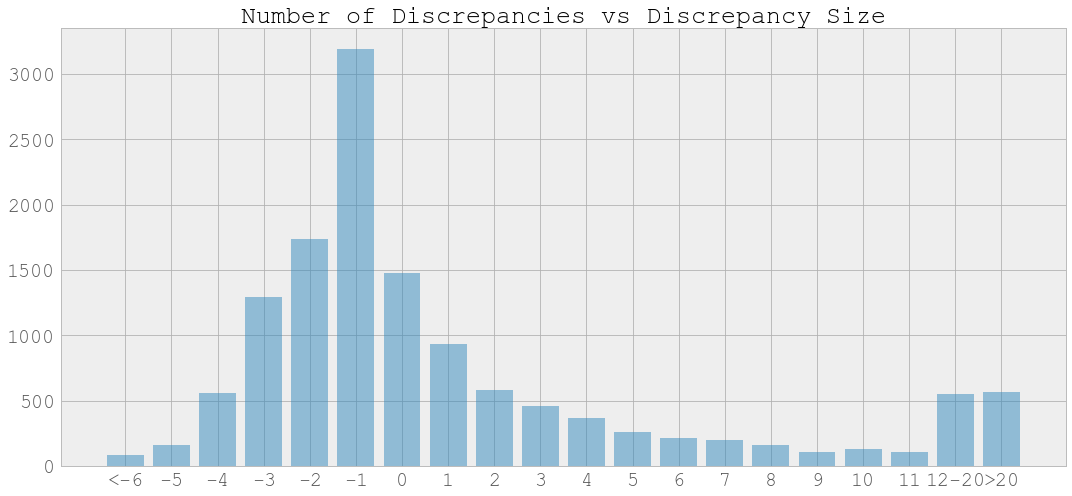

In [10]:
y = [562, 548, 102, 126, 108, 162, 196, 210, 260, 369, 455, 577, 935, 1479, 3191, 1739, 1290, 559, 161, 86]
x = [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5, -6]
labels = [str(i) for i in x]
labels[1] = '12-20'
labels[0] = '>20'
labels[(len(labels)-1)] = '<-6'

plt.figure(figsize = (15,7))
plt.xticks(x, labels)
pd.options.display.mpl_style = 'default'
plt.bar(x, y, align='center', alpha=0.5)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.title("Number of Discrepancies vs Discrepancy Size", fontsize = 25)
plt.tight_layout()
plt.show()


***From the above graph, it seems as though as `segment_total` approaches `path_total`, the count increases. ***

<br>
***More interestingly, as there is an increasing positive difference between `segment_total` and `path_total`, the count decreases. Note that we excluded individual results for discrepancies of size 12 and onwards for the sake space.***

## Digging Deeper- Changing Time Intervals

<br>
The above analysis gives us a good rough idea of what is going on with the data. Clearly not all bluetooth segments represent OD paths, and discrepancies between these data sets can vary depending on other elements in the date (i.e. path total). 

<br>
#### *Joining on Date may cause underrepresentation*

<br>
Notice how we are joining OD and segment data on two variables: date, and userid. We join on date as the time stamps for the data sets vary greatly. Now consider the following scenario:
A car starts its path at 1 AM on a Monday. The bluetooth segment data shows segments with timestamps at 11:40 PM Sunday, 12:30 AM Monday, and 1 AM Monday. By joining on date, in this scenario, the Sunday segment would be missing on the join.

<br> 
We hypothesize that this may be a reason for the under representation of segment data. To mitigate this, we will perform the join on a different time interval. Determining the interval will require some investigation. 

The logic of determining the interval is as follows:

* We Left join `segments` and `complete` on `datetime_bin` and `userid`, only for userid's with multiple timestamps. 
* We look for nulls in the above query. We find userid's with a large amount of null values that also contain a joined timestamp and userid from `complete`. 
* We look at the beginning of the nulls and the end, then we calculate the difference. This will give us an appropriate interval for our interest. 

<br>
We complete the join of interest by creating a view called `joined`. A sample of the first few rows can be seen below.

In [11]:
%%sql

select * from joined limit 5; 

5 rows affected.


userid,datetime_bin,startpoint_name,endpoint_name,cdatetime_bin,cuserid
-9219806034649301548,2018-01-01 00:46:13,CO_UN,CO_BA,2018-01-01 00:46:13,-9219806034649301548
-9219806034649301548,2018-01-01 10:24:05,CO_BA,CO_UN,2018-01-01 10:24:05,-9219806034649301548
-9216702922520912820,2018-01-01 16:03:31,QU_JA,QU_YO,None,None
-9216702922520912820,2018-01-01 16:09:26,QU_YO,QU_UN,None,None
-9214166793301162557,2018-01-01 23:27:13,FB_SP,FR_SP,None,None


We find the userid's with the most nulls by  executing the following query: 

In [12]:
%%sql 
select userid, count(userid) as c
from joined
where cuserid is null
group by userid
order by c desc
limit 5

5 rows affected.


userid,c
1983310123336577193,167
1207754401363453046,149
6673949081404878332,125
-5399468081705131680,94
-6043027741035473340,93


The first three are likely to be taxis. We find the userid with a count of 94. 

Upon investigation of `joined` where userid = -5399468081705131680, it seems the interval (2018-01-01 03:25:03, 2018-01-01 05:04:08) has relatively smooth and continuous timestamps inbetween. The interval length is approximately 1.5 hours. 

<br>
***We choose 1.5 hours as hour interval for analysis.***

## Discrepancies with the New Time Interval

<br>
We adjust our previous join to obtain the following query

In [24]:
%%sql

WITH final as(
SELECT complete.datetime_bin, complete.userid, complete.start as origin, complete.end as destination, complete.path_total, startpoint_name as segment_start, endpoint_name as segment_end
FROM segs
LEFT JOIN alouis2.complete
ON segs.datetime_bin > complete.datetime_bin - INTERVAL '1.5 hour'
AND segs.datetime_bin <= complete.datetime_bin
AND segs.userid = complete.userid
WHERE path_total > 1)

SELECT datetime_bin, userid, count(distinct(final.*)) as segment_total, origin, destination, path_total
FROM final
GROUP BY datetime_bin, userid, origin, destination, path_total
LIMIT 5

5 rows affected.


datetime_bin,userid,segment_total,origin,destination,path_total
2018-01-01 00:00:17,-4109236477481291089,1,du_yo,du_ja,2
2018-01-01 00:01:11,-5833274664015405017,1,du_ja,du_yo,2
2018-01-01 00:02:08,8147950039115731659,1,du_pa,du_ja,2
2018-01-01 00:02:47,1200906276903573645,1,fr_ja,du_ja,5
2018-01-01 00:02:59,-4164760066955224419,2,du_df,qu_ro,3


There are 12205 rows in this table (less than when we joined by date, which makes sense). We find the combos that are a perfect match. 


In [60]:
%%sql
WITH ideals as (WITH final as(
SELECT complete.datetime_bin, complete.userid, complete.start as origin, complete.end as destination, complete.path_total, startpoint_name as segment_start, endpoint_name as segment_end
FROM segs
LEFT JOIN alouis2.complete
ON segs.datetime_bin > complete.datetime_bin - INTERVAL '1.5 hour'
AND segs.datetime_bin <= complete.datetime_bin
AND segs.userid = complete.userid
WHERE path_total > 1)

                
SELECT datetime_bin, userid, count(distinct(final.*)) as segment_total, origin, destination, path_total
FROM final
GROUP BY datetime_bin, userid, origin, destination, path_total
having count(distinct(final.*)) = path_total -1)  

select count(*) from ideals; 

1 rows affected.


count
4261


There are 4261 rows in this table. 4261/12205 = 35%. This is 10% higher than our previous data. 


<br>
***Therefore we estimate 35% of Origin/Destination Paths can be represented via Bluetooth Segment data with our new time interval. ***

## Visualizing Improvement 

<br>
Using our new query, we will investigate the perfect matches, i.e. the segments that perfectly represent an OD Path. We rerun discrepancy size vs number of discrepancies with our newly selected time interval. 


C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


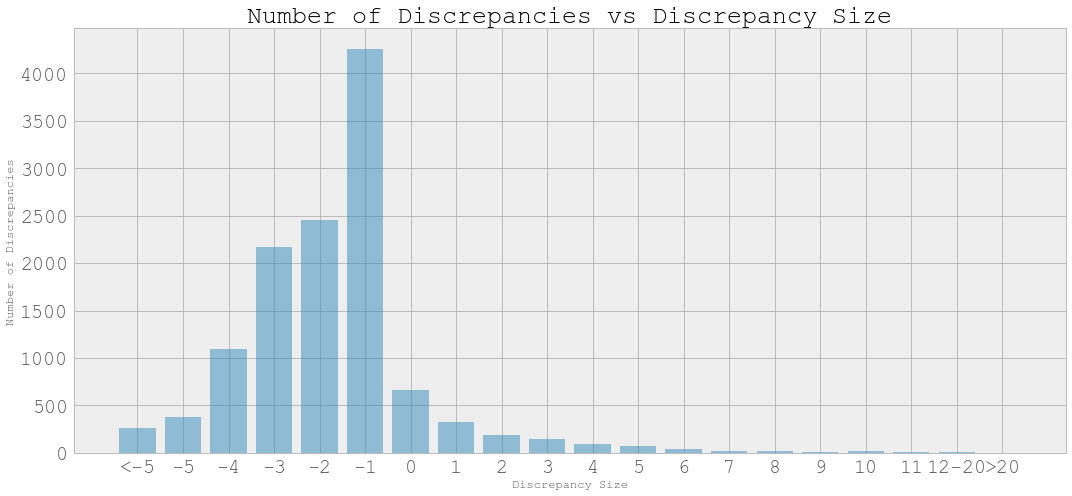

In [14]:
y = [1, 9, 8, 14, 8, 20, 24, 42, 67, 91,  141, 190, 325, 657, 4261, 2452, 2165, 1095, 373, 261]
x = [13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0, -1, -2, -3, -4, -5, -6]

labels = [str(i) for i in x]
labels[1] = '12-20'
labels[0] = '>20'
labels[(len(labels)-1)] = '<-5'

plt.figure(figsize = (15,7))
plt.xticks(x, labels)
pd.options.display.mpl_style = 'default'
plt.bar(x, y, align='center', alpha=0.5)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.title("Number of Discrepancies vs Discrepancy Size", fontsize = 25)
plt.xlabel("Discrepancy Size")
plt.ylabel("Number of Discrepancies")
plt.tight_layout()
plt.show()

***This graph is much different than our previous time interval. The drop from -1 to 0 is extremely sharp, and overall there are are fewer positive discrepancy sizes, i.e. where `segment_total` $>$ `path_total`.***

## Visualizing Representation Percentage vs Path Total

<br>
We hypothesize that as path total increases, the percentage of segment data that represents OD data decreases. Let's graph this: 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


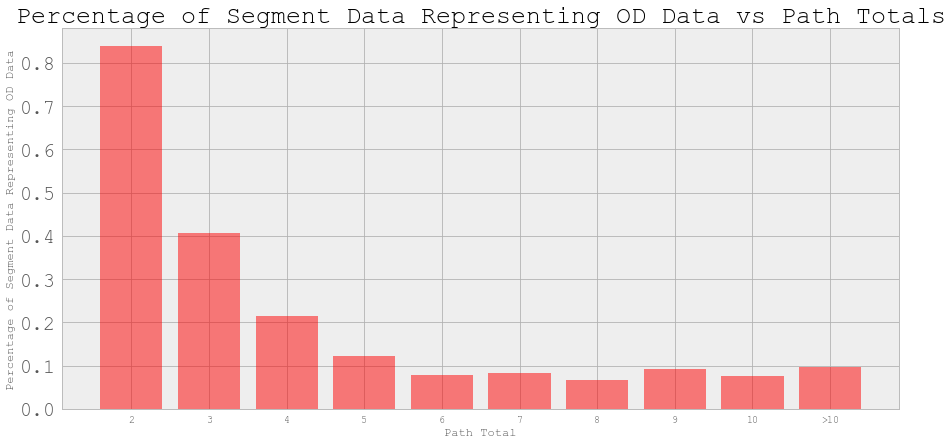

In [54]:
y = [2475/2952, 927/2276,  371/1737, 179/1463,  98/1245, 64/781, 37/552, 29/313, 16/208, 65/678]
x = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
plt.figure(figsize = (15,7))
pd.options.display.mpl_style = 'default'
plt.bar(x, y, align='center', alpha=0.5, color = 'red')
labels = [str(i) for i in x]
labels[len(labels)-1] = '>10' 
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xticks(x, labels)
plt.xlabel("Path Total")
plt.ylabel("Percentage of Segment Data Representing OD Data")
plt.title("Percentage of Segment Data Representing OD Data vs Path Totals", fontsize = 25)
#plt.tight_layout()
plt.show()


***It seems as though our hypothesis is correct- as path total increases, i.e. a path becomes more complex, the percentage of bluetooth segment data that accurately represents OD data decreases.***

# Investigating Perfect Combos
***

## Creating a View with Perfect Combos

<br>
Before we begin to analyze perfect segment/od combos (i.e. for x paths, x-1 segments), we summarize the matches we have in a view in sql. 

<br>
We create three materialized views to help with this, which results in creating the view `perfectcombos` to analyze our matches. Here's what `perfectcombos` looks like: 

In [43]:
%%sql

select * from perfectcombos limit 5; 

5 rows affected.


datetime_bin,userid,origin,destination,path_total,segment_start,segment_end
2018-01-01 10:26:25,-9221220690800223438,fb_yk,fr_un,2,FB_YK,FR_UN
2018-01-01 10:22:01,-9219933307520670431,fb_ba,fr_ba,2,FB_BA,FR_BA
2018-01-01 10:24:05,-9219806034649301548,co_ba,co_un,2,CO_BA,CO_UN
2018-01-01 00:46:13,-9219806034649301548,co_un,co_ba,2,CO_UN,CO_BA
2018-01-01 16:09:44,-9216702922520912820,qu_ja,qu_un,3,QU_YO,QU_UN


***Essentially, this view is a table containing every OD pair that matches with bluetooth segment data, i.e. $x-1$ segment combos for each path_total $x$. Along with this is the end timestmap and userid. ***

## Pivoting Path data

<br>
Our general goal is to see whether these segments correspond to the path the vehicle took in our OD data. Are they the same? If not, how big is the discrepancy? 

<br>
Before we answer such questions, we need to pivot our table `others_path`, as the binary matrix is extremely difficult to read. 

We pivot it by creating a new column `path` containing a list of strings of all the points the vehicle passes along the path. The code for this can be found in the `pivot.ipynb`. Here is our resulting table, which we call `others_pivot`. 

In [44]:
%%sql
select * from others_pivot limit 5;

5 rows affected.


datetime_bin,userid,start,end,path,path_total
2018-01-01 00:00:17,-4109236477481291089,du_yo,du_ja,"['du_yo', 'du_ja']",2
2018-01-01 00:01:08,-1672501126208601408,du_pa,qu_bv,"['du_pa', 'qu_bv']",2
2018-01-01 00:01:11,-5833274664015405017,du_ja,du_yo,"['du_ja', 'du_yo']",2
2018-01-01 00:02:08,8147950039115731659,du_pa,du_ja,"['du_pa', 'du_ja']",2
2018-01-01 00:02:11,2538540623439968621,kn_df,du_df,"['kn_df', 'du_df']",2


Much better. The data is much more easier to read. Now, we join this data with our view with matches, `perfectcombos`. We will read this into a pandas dataframe as we will use pandas to analyze this join. 

In [45]:
string = '''SELECT * FROM alouis2.perfectcombos 
            NATURAL JOIN others_pivot'''
df = pandasql.read_sql(pg.SQL(string), con)
df.head(5)

,datetime_bin,userid,path_total,origin,destination,segment_start,segment_end,start,end,path
0,2018-01-01 10:26:25,-9221220690800223438,2,fb_yk,fr_un,FB_YK,FR_UN,fb_yk,fr_un,"['fb_yk', 'fr_un']"
1,2018-01-01 10:22:01,-9219933307520670431,2,fb_ba,fr_ba,FB_BA,FR_BA,fb_ba,fr_ba,"['fb_ba', 'fr_ba']"
2,2018-01-01 10:24:05,-9219806034649301548,2,co_ba,co_un,CO_BA,CO_UN,co_ba,co_un,"['co_ba', 'co_un']"
3,2018-01-01 00:46:13,-9219806034649301548,2,co_un,co_ba,CO_UN,CO_BA,co_un,co_ba,"['co_un', 'co_ba']"
4,2018-01-01 16:09:44,-9216702922520912820,3,qu_ja,qu_un,QU_YO,QU_UN,qu_ja,qu_un,"['qu_ja', 'qu_yo', 'qu_un']"


***Now we have a comprehensive view of all our perfect combos. ***

## Discrepancies within Perfect Combos

<br>
Recall that our perfect combo records are simply an estimation, i.e. for a path total of $x$, there are logically $x-1$ segments. However, do these segments correspond to the path? I.e. for every segment, does each intersection fall in the list in our `path` column? Our next step in the analysis is to investigate this discrepancy.

### Path Totals of 2 
We suspect that for path_totals of two, each intersection falls in the list in our `path` column. Let's verify this result:

In [3]:
string = '''SELECT datetime_bin, userid, path_total, origin, destination, 
            segment_start, segment_end, path FROM 
            (SELECT * FROM perfectcombos
            NATURAL JOIN others_pivot 
            WHERE path_total = 2) f'''
twoonly = pandasql.read_sql(pg.SQL(string), con)

def find_2(df):
    l = []
    for i in range(len(df)): 
        if df['segment_start'].values[i].lower() not in df['path'].values[i] or df['segment_end'].values[i].lower() not in df['path'].values[i]:
            l.append(df.loc[i,])
    return l
    
len(find_2(twoonly))/len(twoonly) * 100 

7.118385991625428

***Not what we were expecting.***

<br>
***For path totals of 2, 7.12% of the paths have corresponding segments do not fall inside the path list. ***


We will put the list generated by `find(df)` in to a dataframe. 

In [4]:
notmatching_2 = pd.DataFrame.from_records(find_2(twoonly), columns=('datetime_bin', 'userid', 'path_total', 'origin', 'destination', 'segment_start', 'segment_end', 'path'))
notmatching_2.head(3)

,datetime_bin,userid,path_total,origin,destination,segment_start,segment_end,path
0,2018-01-01 19:40:30,-9120335971942659923,2,fb_sp,fb_sp,FB_SP,FB_YK,"['fb_sp', 'fb_sp']"
1,2018-01-01 11:29:45,-9118201504088476968,2,fr_un,fb_sp,FR_YO,FR_UN,"['fr_un', 'fb_sp']"
2,2018-01-01 19:38:02,-8971740012410652059,2,qu_pa,qu_pa,QU_BV,QU_PA,"['qu_pa', 'qu_pa']"


### Path Totals > 2

Given this discrepancy exists for path totals of 2, i.e. a car going from Point A to Point B, we now have some reason to believe that this discrepancy exists for more complex paths, and may even increase.

<br>
We will make a function that finds the rows where not all segments fall in our path list. 

In [5]:
string = '''SELECT datetime_bin, userid, path_total, origin, destination, 
            segment_start, segment_end, path FROM 
            (SELECT * FROM perfectcombos
            NATURAL JOIN others_pivot 
            WHERE path_total != 2) f'''
df = pandasql.read_sql(pg.SQL(string), con)
def find(df): 
    l = []
    i = 0 
    while i < len(df)-1: 
        if df['datetime_bin'].values[i] == df['datetime_bin'].values[i+1]:
            if df['segment_start'].values[i].lower() not in df['path'].values[i] or df['segment_end'].values[i].lower() not in df['path'].values[i]:
                l.append(df.loc[i,])
                i += 1
            else:
                i += 1
        else:
            i += 1
    return l 

find(df)[0:3]

[datetime_bin                                   2018-01-01 10:51:16
 userid                                        -9191093230214430340
 path_total                                                       7
 origin                                                       co_ba
 destination                                                  we_bj
 segment_start                                                DU_DF
 segment_end                                                  DU_BA
 path             ['co_ba', 'du_ba', 'qu_ba', 'rm_ba', 'ad_ba', ...
 Name: 4, dtype: object,
 datetime_bin                                   2018-01-01 10:51:16
 userid                                        -9191093230214430340
 path_total                                                       7
 origin                                                       co_ba
 destination                                                  we_bj
 segment_start                                                QU_DF
 segment_end           

We put this list into a dataframe called `notmatching`. This dataframe can be seen below: 

In [6]:
notmatching = pd.DataFrame.from_records(find(df), columns=('datetime_bin', 'userid', 'path_total', 'origin', 'destination', 'segment_start', 'segment_end', 'path'))
notmatching.head(3)

,datetime_bin,userid,path_total,origin,destination,segment_start,segment_end,path
0,2018-01-01 10:51:16,-9191093230214430340,7,co_ba,we_bj,DU_DF,DU_BA,"['co_ba', 'du_ba', 'qu_ba', 'rm_ba', 'ad_ba', ..."
1,2018-01-01 10:51:16,-9191093230214430340,7,co_ba,we_bj,QU_DF,DU_DF,"['co_ba', 'du_ba', 'qu_ba', 'rm_ba', 'ad_ba', ..."
2,2018-01-01 10:51:16,-9191093230214430340,7,co_ba,we_bj,KN_DF,QU_DF,"['co_ba', 'du_ba', 'qu_ba', 'rm_ba', 'ad_ba', ..."


In [7]:
string = '''SELECT distinct(datetime_bin, userid) FROM 
            (SELECT * FROM perfectcombos
            NATURAL JOIN others_pivot
            WHERE path_total != 2) f; '''
df = pandasql.read_sql(pg.SQL(string), con)

len(notmatching.groupby(['datetime_bin', 'userid']).count())/len(df) * 100


11.900826446280991

***So the percentage of paths whose segments do not correspond to the path list for path totals > 2 is 11.9%***

### All Path Totals 
We combine `nonmatching_2` with `nonmatching`, to get a complete dataframe containing paths with mismatching segments. First, we find a grand total percentage of paths who have segments that do not fall into the path list.  We then put this dataframe into sql. 

In [8]:
notmatching = notmatching_2.append(notmatching)
notmatching.head(5)

,datetime_bin,userid,path_total,origin,destination,segment_start,segment_end,path
0,2018-01-01 19:40:30,-9120335971942659923,2,fb_sp,fb_sp,FB_SP,FB_YK,"['fb_sp', 'fb_sp']"
1,2018-01-01 11:29:45,-9118201504088476968,2,fr_un,fb_sp,FR_YO,FR_UN,"['fr_un', 'fb_sp']"
2,2018-01-01 19:38:02,-8971740012410652059,2,qu_pa,qu_pa,QU_BV,QU_PA,"['qu_pa', 'qu_pa']"
3,2018-01-01 11:42:19,-8876820604301638763,2,fr_ja,fr_ja,FR_JA,KN_JA,"['fr_ja', 'fr_ja']"
4,2018-01-01 10:41:12,-8832865037004904890,2,fr_ba,co_ba,FR_SP,FR_BA,"['fr_ba', 'co_ba']"


In [9]:
string = '''SELECT distinct(datetime_bin, userid) FROM 
            (SELECT * FROM perfectcombos
            NATURAL JOIN others_pivot) f; '''
df = pandasql.read_sql(pg.SQL(string), con)
len(notmatching.groupby(['datetime_bin', 'userid']))/len(df) * 100

8.639108221086856

***So the total percentage of paths who have segments that do not fall into corresponding path list is 8.64%.***

## Visualizing Results

<br>
We summarize our above results with the following graph: 

C:\Users\alouis2\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2862: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


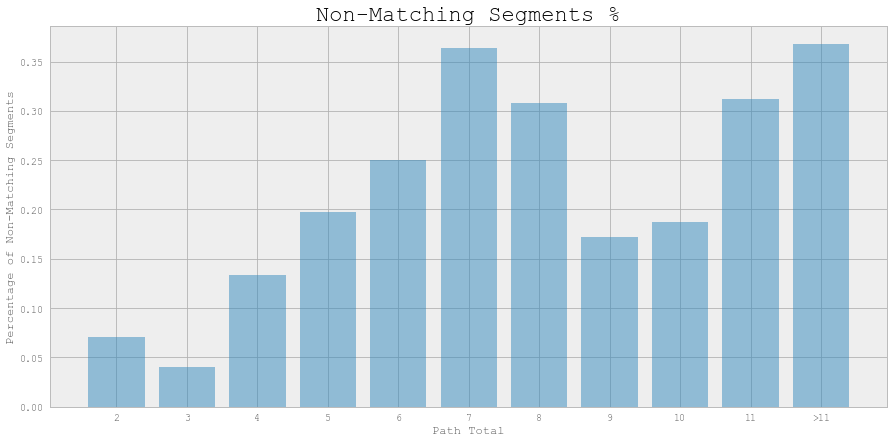

In [10]:
string = '''SELECT * FROM alouis2.perfectcombos 
            NATURAL JOIN others_pivot'''
df = pandasql.read_sql(pg.SQL(string), con)

x = [[2, len(notmatching.loc[notmatching['path_total'] == 2])/len(df.loc[df['path_total'] ==2])], 
     [3, len(notmatching.loc[notmatching['path_total'] == 3].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==3].groupby(['datetime_bin', 'userid']))],
     [4, len(notmatching.loc[notmatching['path_total'] == 4].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==4].groupby(['datetime_bin', 'userid']))],
     [5, len(notmatching.loc[notmatching['path_total'] == 5].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==5].groupby(['datetime_bin', 'userid']))],
     [6, len(notmatching.loc[notmatching['path_total'] == 6].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==6].groupby(['datetime_bin', 'userid']))],
     [7, len(notmatching.loc[notmatching['path_total'] == 7].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==7].groupby(['datetime_bin', 'userid']))],
     [8, len(notmatching.loc[notmatching['path_total'] == 8].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==8].groupby(['datetime_bin', 'userid']))],
     [9, len(notmatching.loc[notmatching['path_total'] == 9].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==9].groupby(['datetime_bin', 'userid']))],
     [10, len(notmatching.loc[notmatching['path_total'] == 10].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==10].groupby(['datetime_bin', 'userid']))],
     [11, len(notmatching.loc[notmatching['path_total'] == 11].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total'] ==11].groupby(['datetime_bin', 'userid']))],
     [12, len(notmatching.loc[notmatching['path_total'] > 11].groupby(['datetime_bin', 'userid']))/len(df.loc[df['path_total']  > 11].groupby(['datetime_bin', 'userid']))]]
summary = pd.DataFrame(x, columns = ['Path Total', 'Non-Matching Segments %'])
labels = list(summary['Path Total'])
labels = [str(i) for i in labels]
labels[8] = '10'
labels[9] = '11'
labels[10] = '>11'

pd.options.display.mpl_style = 'default'
plt.figure(figsize = (15,7))
plt.bar((summary['Path Total']), summary['Non-Matching Segments %'], align='center', alpha=0.5)
plt.xticks(list(summary['Path Total']), labels)
plt.rc('ytick', labelsize=20) 
plt.title("Non-Matching Segments %", fontsize = 22)
plt.xlabel("Path Total")
plt.ylabel("Percentage of Non-Matching Segments")
plt.show()

***From the above, we see a pattern: as the path total increases (i.e. the path becomes more complex), the percentage of non-matching segments increases.***

## A few Examples 

<br>
Below are a few examples of missing segments, in addition to corresponding timestamps for the time segments. We inlcude these examples to better illustrate what it means for a path to seemingly correspond to segments, but not all segment intersections are present in the path. 

### Example 1

<br>
In this example, we can see that for all `startpoint_name` and `endpoint_name` values fall into our path list except for one: `WE_YO`. 

In [55]:
%%sql 

with example as (select * from perfectcombos 
natural join others_pivot
where path_total = 6
and userid = -9158546835467209628)

select segs.userid, example.datetime_bin as endtime,  segs.datetime_bin as timestamp, example.origin, example.destination,  segs.startpoint_name, segs.endpoint_name, example.path, example.path_total  from segs
inner join example on example.userid = segs.userid and example.segment_start = segs.startpoint_name and example.segment_end = segs.endpoint_name
where segs.userid = -9158546835467209628
order by segs.datetime_bin; 

5 rows affected.


userid,endtime,timestamp,origin,destination,startpoint_name,endpoint_name,path,path_total
-9158546835467209628,2018-01-01 23:21:59,2018-01-01 22:12:39,fb_sp,fb_yk,WE_YO,WE_UN,"['fb_sp', 'we_bj', 'kn_un', 'we_un', 'fr_un', 'fb_yk']",6
-9158546835467209628,2018-01-01 23:21:59,2018-01-01 22:17:38,fb_sp,fb_yk,WE_UN,WE_BJ,"['fb_sp', 'we_bj', 'kn_un', 'we_un', 'fr_un', 'fb_yk']",6
-9158546835467209628,2018-01-01 23:21:59,2018-01-01 23:21:12,fb_sp,fb_yk,KN_UN,FR_UN,"['fb_sp', 'we_bj', 'kn_un', 'we_un', 'fr_un', 'fb_yk']",6
-9158546835467209628,2018-01-01 23:21:59,2018-01-01 23:21:59,fb_sp,fb_yk,FB_SP,FB_YK,"['fb_sp', 'we_bj', 'kn_un', 'we_un', 'fr_un', 'fb_yk']",6
-9158546835467209628,2018-01-01 23:21:59,2018-01-01 23:21:59,fb_sp,fb_yk,FR_UN,FB_YK,"['fb_sp', 'we_bj', 'kn_un', 'we_un', 'fr_un', 'fb_yk']",6


### Example 2

<br>
Here are a few paths of path totals of 2. For the first path, `FR_SP` is missing, and for the second path `FR_YO` is missing. 

In [15]:
%%sql 

with example as (select * from perfectcombos 
natural join others_pivot
where path_total = 2
and userid in (-9118201504088476968,-8832865037004904890)
)

select segs.userid,example.datetime_bin as endtime,  segs.datetime_bin as timestamp, example.origin, example.destination,  segs.startpoint_name, segs.endpoint_name, example.path, example.path_total  from segs
inner join example on example.userid = segs.userid and example.segment_start = segs.startpoint_name and example.segment_end = segs.endpoint_name
where segs.userid in (-9118201504088476968,-8832865037004904890)
order by segs.datetime_bin; 


2 rows affected.


userid,endtime,timestamp,origin,destination,startpoint_name,endpoint_name,path,path_total
-8832865037004904890,2018-01-01 10:41:12,2018-01-01 10:38:15,fr_ba,co_ba,FR_SP,FR_BA,"['fr_ba', 'co_ba']",2
-9118201504088476968,2018-01-01 11:29:45,2018-01-01 11:26:07,fr_un,fb_sp,FR_YO,FR_UN,"['fr_un', 'fb_sp']",2


### Example 3

<br>
Below is a more complex path. `CO_PA`, `CO_UN`, `CO_BA` do not fall into the path list. 

In [14]:
%%sql

with example as (select * from perfectcombos 
natural join others_pivot

where userid = -8980809001129171111)

select segs.userid, example.datetime_bin as endtime, segs.datetime_bin as timestamp,  example.origin, example.destination,  segs.startpoint_name, segs.endpoint_name, example.path, example.path_total  from segs
inner join example on example.userid = segs.userid and example.segment_start = segs.startpoint_name and example.segment_end = segs.endpoint_name
where segs.userid = -8980809001129171111
order by segs.datetime_bin

9 rows affected.


userid,endtime,timestamp,origin,destination,startpoint_name,endpoint_name,path,path_total
-8980809001129171111,2018-01-01 01:28:40,2018-01-01 00:11:00,du_un,rm_sp,CO_PA,CO_UN,"['du_un', 'qu_un', 'rm_un', 'fb_sp', 'fb_ba', 'fr_ba', 'qu_ba', 'ad_sp', 'qu_sp', 'rm_sp']",10
-8980809001129171111,2018-01-01 01:28:40,2018-01-01 00:16:22,du_un,rm_sp,CO_UN,CO_BA,"['du_un', 'qu_un', 'rm_un', 'fb_sp', 'fb_ba', 'fr_ba', 'qu_ba', 'ad_sp', 'qu_sp', 'rm_sp']",10
-8980809001129171111,2018-01-01 01:28:40,2018-01-01 00:59:34,du_un,rm_sp,CO_UN,DU_UN,"['du_un', 'qu_un', 'rm_un', 'fb_sp', 'fb_ba', 'fr_ba', 'qu_ba', 'ad_sp', 'qu_sp', 'rm_sp']",10
-8980809001129171111,2018-01-01 01:28:40,2018-01-01 01:00:49,du_un,rm_sp,DU_UN,QU_UN,"['du_un', 'qu_un', 'rm_un', 'fb_sp', 'fb_ba', 'fr_ba', 'qu_ba', 'ad_sp', 'qu_sp', 'rm_sp']",10
-8980809001129171111,2018-01-01 01:28:40,2018-01-01 01:06:47,du_un,rm_sp,QU_UN,QU_SP,"['du_un', 'qu_un', 'rm_un', 'fb_sp', 'fb_ba', 'fr_ba', 'qu_ba', 'ad_sp', 'qu_sp', 'rm_sp']",10
-8980809001129171111,2018-01-01 01:28:40,2018-01-01 01:09:46,du_un,rm_sp,QU_SP,QU_BA,"['du_un', 'qu_un', 'rm_un', 'fb_sp', 'fb_ba', 'fr_ba', 'qu_ba', 'ad_sp', 'qu_sp', 'rm_sp']",10
-8980809001129171111,2018-01-01 01:28:40,2018-01-01 01:16:38,du_un,rm_sp,FR_BA,FB_BA,"['du_un', 'qu_un', 'rm_un', 'fb_sp', 'fb_ba', 'fr_ba', 'qu_ba', 'ad_sp', 'qu_sp', 'rm_sp']",10
-8980809001129171111,2018-01-01 01:28:40,2018-01-01 01:25:56,du_un,rm_sp,FB_BA,FB_SP,"['du_un', 'qu_un', 'rm_un', 'fb_sp', 'fb_ba', 'fr_ba', 'qu_ba', 'ad_sp', 'qu_sp', 'rm_sp']",10
-8980809001129171111,2018-01-01 01:28:40,2018-01-01 01:28:40,du_un,rm_sp,RM_UN,RM_SP,"['du_un', 'qu_un', 'rm_un', 'fb_sp', 'fb_ba', 'fr_ba', 'qu_ba', 'ad_sp', 'qu_sp', 'rm_sp']",10


# Investigating Non-Matches 
***
Previously, we estimated that 35% of OD data can be represented by segment data (excluding the discrepancies found above). We now wish to investigate the other 65%. 